In [1]:
import numpy as np
import time
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
%matplotlib inline

from VecEnv import EIEnv
from scipy.optimize import differential_evolution

In [5]:
env = EIEnv()

/home/zhaoming/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
env.dt

0.016666666666666666

In [12]:
def evaluate(K1,K2,env,test_runs=10):
    Values=np.zeros(test_runs)
    F=np.zeros((3,7))
    F[0,1:5]=[1,-1,1,1]
    F[1,5]=1
    F[2,6]=1
    for i in range(test_runs):
        observation = env.reset()
        rewards=[]
        while True:
            observation_in=F@env.observation_scaler(observation)
            action=np.tanh(K1@observation_in+K2)
            # gather env data, reset done envs and update their obs
            observation, reward, done, info = env.step(action)
            rewards.append(reward)
            if done:
                _, reward, _, info = env.step(action)
                break
        V_x=reward/(1-gamma)
        for reward in reversed(rewards):
            V_x=reward+V_x*gamma
        Values[i]=V_x
    return Values.mean()

In [13]:
evaluate(np.random.randn(3,3),np.random.randn(3,),env)

NameError: name 'gamma' is not defined

In [8]:
def eva(k):
    return evaluate(k[:9].reshape((3,3)),k[9:],EIEnv(env_id=22,gamma=0.96),test_runs=30)

In [9]:
eva(np.random.randn(12))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 7 is different from 8)

In [555]:
#%%capture OUT
init=np.repeat(result.x,15).reshape((-1,15)).T
#init='latinhypercube'
bounds=[(-1,1) for _ in range(12)]
result = differential_evolution(eva, bounds,init=init,updating='deferred',polish=False,workers=16,popsize=30,maxiter=1000,disp=False)

In [556]:
K1,K2=result.x[:9].reshape((3,3)),result.x[9:]

In [557]:
env=EIEnv(env_id=22,gamma=0.96)
[seed]=env.seed()
gamma=0.96

In [558]:
env.seed(976544343456131)
steps=[]
observation = env.preset(soc=0.61)
F=np.zeros((3,8))
F[0,1:6]=[1,-1,1,1,1]
F[1,6]=1
F[2,7]=1
while True:
    observation_in=F@env.observation_scaler(observation)
    action = np.tanh(K1@observation_in+K2)
    int_obs+=observation_in*env.dt
    #action=torch.tanh(policies_mu)
    # gather env data, reset done envs and update their obs
    observation, reward, done, info = env.step(action)
    steps.append((np.array([reward]), action, observation))
    if done:
        _, reward, _, info = env.step(action)
        break

n_step=len(steps)-1
#Q_x_a=final_value_net.data.detach().cpu().numpy()
Q_x_a=reward/(1-gamma)
out=[None] * n_step
for i in reversed(range(n_step)):
    reward, action, observation=steps[i]
    Q_x_a=reward+Q_x_a*gamma
    out[i]=observation, action, reward, Q_x_a

x,a,r,Q_x_a=map(lambda l:np.concatenate(l),zip(*out))
x=x.reshape((-1,env.observation_space.shape[0]))
a=a.reshape((-1,env.action_space.shape[0]))


In [559]:
observation_in

array([1.21654003, 0.        , 0.99742198])

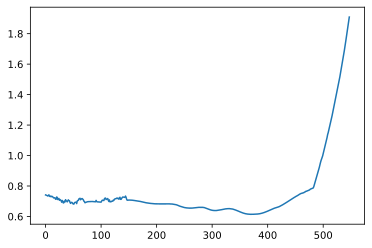

In [560]:
plt.plot(r)

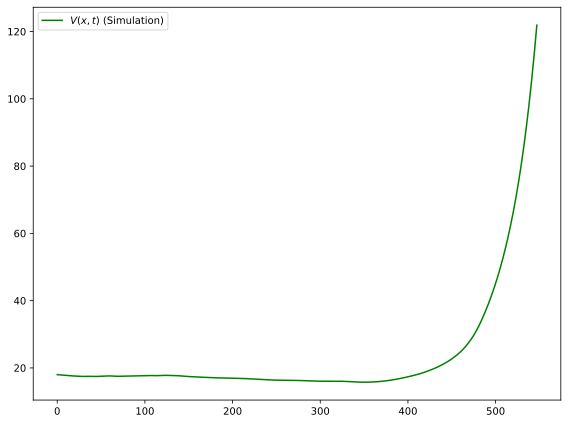

In [561]:
fig, (ax1)=plt.subplots(1,1,figsize=(8,6))
ax1.plot(Q_x_a[:],'g',label='$V(x,t)$ (Simulation)')
#ax1.plot(Q_net[:],'r',label='$V(x,t)$ (Learned)')
#ax1.plot(Q[:],'g--',label='Q(x,a)* (Simulation with Random Action)')
ax1.legend()

fig.tight_layout()
fig.show()

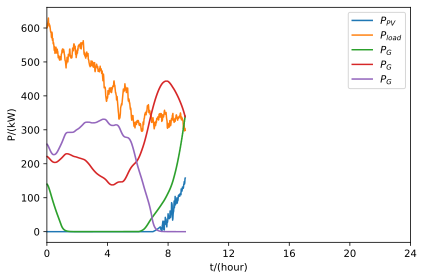

In [562]:
plt.plot(x[:,0],x[:,1],label=r'$P_{PV}$')
plt.plot(x[:,0],x[:,2],label=r'$P_{load}$')
plt.step(x[:,0],x[:,3:6],label=r'$P_G$')
plt.ylabel('P/(kW)')
plt.xlabel('t/(hour)')
plt.xlim([0,24])
plt.xticks(np.arange(0,25,4))
plt.legend()
plt.tight_layout()

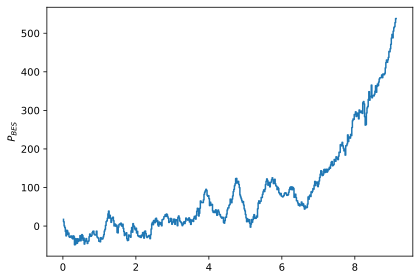

In [563]:
plt.step(x[:,0],x[:,1]-x[:,2]+x[:,3]+x[:,4]+x[:,5])
plt.ylabel(r'$P_{BES}$')
plt.tight_layout()

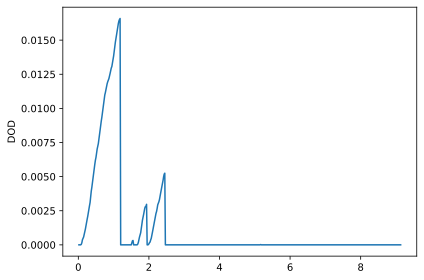

In [564]:
plt.plot(x[:,0],x[:,6])
plt.ylabel('DOD')
plt.tight_layout()

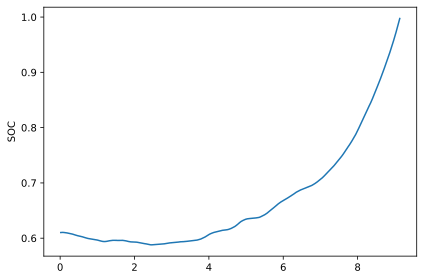

In [565]:
plt.plot(x[:,0],x[:,7])
plt.ylabel('SOC')
plt.tight_layout()

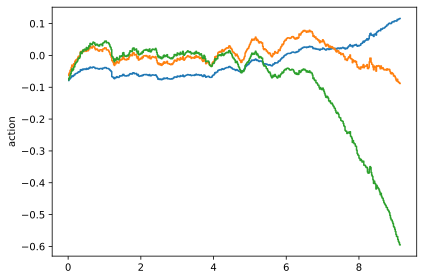

In [566]:
plt.step(x[:,0],a)
plt.ylabel('action')
plt.tight_layout()

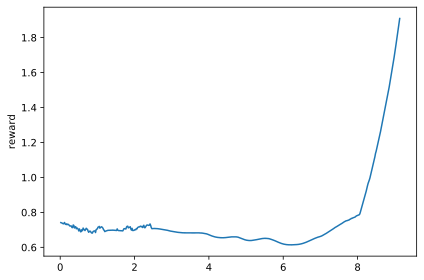

In [567]:
plt.plot(x[:,0],r)
plt.ylabel('reward')
plt.tight_layout()